
# Experiment 1 : Concept Drift Detection Using Autoencoders in Data Streams Processing ( with RBM Dataset)

In [214]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import tensorflow
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers

import scipy.stats as stats
import math

from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson


import warnings
warnings.filterwarnings("ignore")

##  S1 dataset generated with RBM with a static probability distribution

In [215]:
s1=pd.read_csv("energy_dataset1.txt",header=None , delimiter=' ')

In [216]:
s1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1
1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1
2,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1
3,1,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,0


In [217]:
s1.shape

(2000000, 20)

## S2 Datset generated with RBM with a static Probability Distribution

In [218]:
s2=pd.read_csv("energy_dataset2.txt",header=None , delimiter=' ')

In [219]:
s2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,0,0,0,1,0,1,1,1,0,1,1,0,0,1,1
1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1
2,1,1,0,1,0,0,0,0,1,0,1,1,1,0,1,1,1,1,1,0
3,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1
4,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1,1


In [220]:
s2.shape

(2000000, 20)

## Sudden Drift Dataset : First 500000 records have been taken from S1 and Rest from S2

In [221]:
# Data has been generated by the researcher of the referenced paper and is avialble to upload directly
Sd=pd.read_csv("suddendrift_energy.txt",header=None , delimiter=' ')

In [222]:
Sd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1
1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1
2,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1
3,1,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,0


In [223]:
Sd.shape

(800000, 20)

###  Gradual Drift Dataset : First 500000 records taken from S1 , [500000:600000] with a probability (600000-i)/100000 from S1 and with a probability (i-500000)/100000 from S2 , Rest taken from S2

In [224]:
# Data has been generated by the researcher of the referenced paper and is avialble to upload directly
Gd=pd.read_csv("gradualdrift_energy.txt",header=None , delimiter=' ')

In [225]:
Gd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1
1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1
2,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1
3,1,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,0


In [226]:
Gd.shape

(800000, 20)

# Working with Sudden Drift Data 

In [227]:
Sd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1
1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1
2,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1
3,1,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,0


In [228]:
Sd.shape

(800000, 20)

In [229]:
sd_train=Sd[0:400000]

In [230]:
sd_train.shape

(400000, 20)

# Data Preparation 

In [231]:
def encode_all(data):
       
    # Apply one-hot encoding to categorical attributes
    for col in data.columns:
        if (data[col].dtype=='object'): 
            data = pd.get_dummies(data, columns=[col])
   # Apply Minmax Normalization 
    for col in data.columns:
        if ((data[col].dtype=='float64')or(data[col].dtype=='int64')): 
            data[col] = np.round((data[col] - data[col].min()) / (data[col].max() - data[col].min()) ,3)  
    
     
    train=data[0:int(len(data)*0.80)]  
    validation_set=data[int((0.80*len(data))):int(len(data)*0.90)] 
    test=data[int((0.90*len(data))):len(data)]         
       
  
    return train, validation_set,test 

In [232]:
train,validation_set,test=encode_all(sd_train) #test is validation set

In [233]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319996,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
319997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
319998,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0


In [234]:
train.shape

(320000, 20)

In [235]:
def autoencoder (train,epochs,validation_set):
    
    # set bottleneck 1/3 of the input layer size
    encoding_dim = int(np.floor(train.shape[-1]/3))
    
    # input layer size= # of attributes in the dataset after one-hot encoding
    input_layer = tensorflow.keras.Input(shape=train.shape[1:]) # Input Layer
    
    encoded = layers.Dense(encoding_dim, activation='sigmoid')(input_layer) # Code Layer
    decoded = layers.Dense(train.shape[1], activation='sigmoid')(encoded) # Output Laye
       
    
    autoencoder = tensorflow.keras.Model(input_layer, decoded)
    # above model maps an input to its reconstruction 
    
    encoder = tensorflow.keras.Model(input_layer, encoded)
    # above model maps input to its encoded representation 
    
   
    encoded_input = tensorflow.keras.Input(shape=(encoding_dim,))# Encoded Input
    decoder_layer = autoencoder.layers[-1]# Retrieve last layer of autoencoder model defined above
    decoder = tensorflow.keras.Model(encoded_input, decoder_layer(encoded_input))# Decoder Model
          
    autoencoder.compile(optimizer='adam', loss='mse') # Train autoencoder 
    history=autoencoder.fit(train,train, 
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_data=(validation_set, validation_set)).history
    return  autoencoder , history

In [236]:
def train_encoders(train,epochs,validation_set):
    
    print("Training Autoencoder ")
    print (train.shape)
    print (validation_set.shape)
    encoder, history = autoencoder(train,epochs,validation_set)
  
    return encoder , history

#### Uncomment and run. 
encoder, history=train_encoders(train,100,validation_set)

In [241]:
def mse_predictions(test, encoder):
    #test=data[int((0.66*len(data))):len(data)-1]
    #pos_test, neg_test=encode(test)
    #Y_test=test['class']
    #X_test=test.drop(['class'],axis=1)
    test=np.array(test)
    predictions=[]
    for i in range(0, test.shape[0]):
        ROW = np.array([test[i]])
        pred= encoder.predict(ROW) 
        mse = np.mean(np.power(test[i] - pred, 2))
        predictions.append(mse)
        #print(test[i] ,pred,mse)
    return predictions

In [377]:
def plot_results(predictions):
    df=pd.DataFrame(predictions,columns=['MSE'])
  
    df['MSE']=df['MSE'].round(2)
      
      
    f, axes = plt.subplots(1, 2,figsize=(16,4))
    axes[0].set_title('Boxplot of Reconstruction Error') 
    #axes[0].xlabel('Reconstruction Error')
    sns.boxplot(x=df['MSE'], data=df, ax=axes[0])
    plt.savefig('Batch_Error_Boxlot.png')
   
    axes[1].set_title('Distribution Plot of Reconstruction Error')
    #axes[1].xlabel('Reconstruction Error')     
    sns.distplot(x=df['MSE'],  ax=axes[1])
    plt.savefig('distribution_plot.png')
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("Reconstruction Error Plot")
    plt.xlabel('Data Stream')
    plt.plot(df['MSE'],label="Reconstruction Error")
    plt.savefig('error_line_plot.png')
   
    plt.legend()
    plt.show()   
  

In [250]:
def plot_distplot(predictions):
    df=pd.DataFrame(predictions,columns=['MSE'])
   
    df['MSE']=df['MSE'].round(2)
               
    f, axes = plt.subplots(figsize=(8,4))
    axes.set_title('Distribution plot for Reconstruction Error')
    plt.xlabel('Reconstruction Error')
    sns.distplot(x=df['MSE'])
    plt.savefig('dist_plot.png')
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("Reconstruction Error Plot")
    plt.xlabel('Data Stream ')
    plt.ylabel('Recons. Error ')
    plt.plot(df['MSE'],label="Reconstruction Error")
    plt.savefig('line_plot.png')
    plt.legend()
    plt.show()  
    

In [244]:
# Shapiro-Wilk Test
def Shapiro_Wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.10f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [245]:
# D'Agostino and Pearson's Test
def D_Agostino(data):
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [246]:
# Anderson-Darling Test
def Anderson_Darling(data):
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

## Make Predictions on Test Data 

In [247]:
predictions_test=mse_predictions(test,encoder)

No handles with labels found to put in legend.


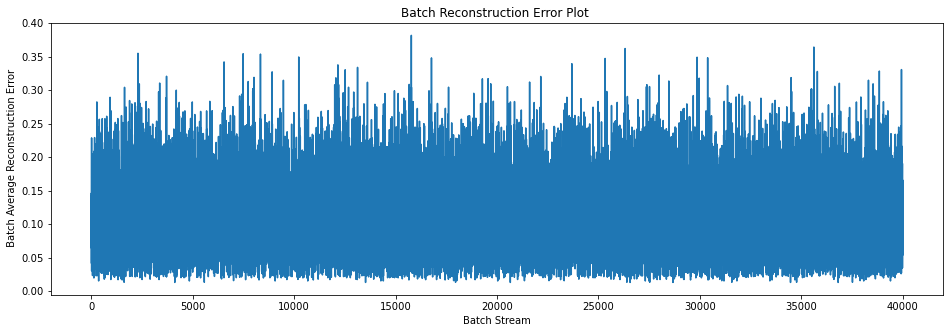

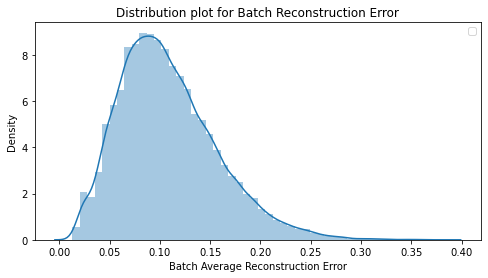

In [400]:
plot_batch_mse(predictions_test)

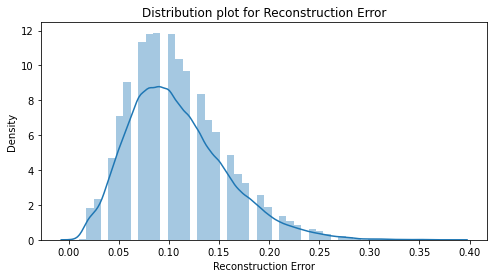

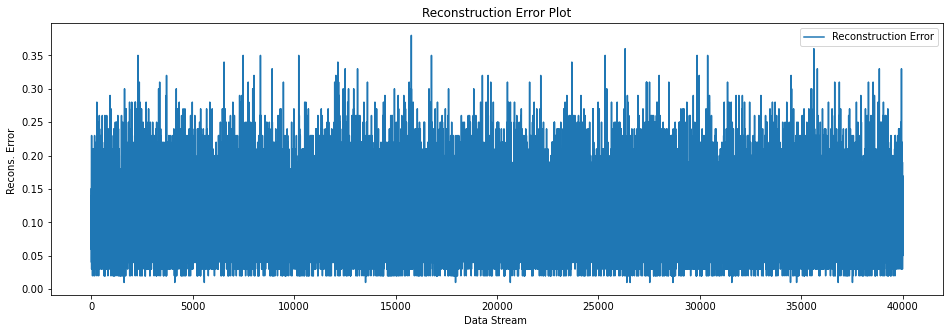

In [399]:
plot_distplot(predictions_test)

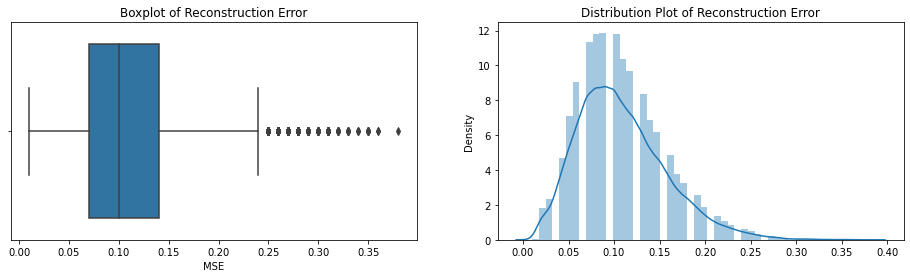

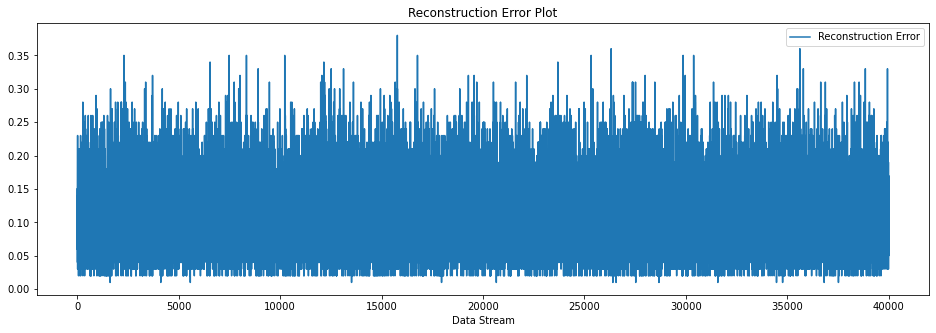

In [378]:
plot_results(predictions_test)

In [257]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                140       
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________


In [258]:
#Plot the model loss(train/test) for give number of epochs
def plot_loss(history):
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Validation')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.ylim(ymin=0.70,ymax=1)
    plt.show()

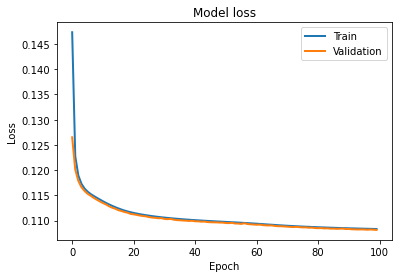

In [259]:
plot_loss(history)

In [260]:
def make_batches(data, batch_size):
    data=np.array(data)
    batches={}
    
    count=0
    for index in range(0,data.shape[0],batch_size):
        batches[count]=data[index:min(index+batch_size,data.shape[0]),:]
        count+=1
    return batches
    #print(batch.shape) 

In [261]:
batches=make_batches(test,32)

In [262]:
def compute_instance_loss_batch_loss(batch,batch_size,encoder):
    mse_list=[]
    mse_sum=0  
    for i in range(0,batch.shape[0]):
        ROW = np.array([batch[i]])
        pred= encoder.predict(ROW) 
        mse = np.round(np.mean(np.power(batch[i] - pred, 2)),5)
        mse_list.append(mse)
        mse_sum+=mse
    avg_mse=mse_sum/batch_size
    return mse_list,avg_mse   

In [264]:
def check_all_batch_normality(batches,encoder,batch_size):
    batch_avg_mse=[]
    batch_mse_values={}
    for b in batches:
        #print("\n ********************")
        #print('Batch: {}'.format(b))
        mse_list,average_mse=compute_instance_loss_batch_loss(batches[b],batch_size,encoder)
        #plot_results(mse_list)
        
        #print("\nShapiro_Wilk Test")
        #Shapiro_Wilk(mse_list)
        #print("D_Agostino Test")
        #D_Agostino(mse_list)
        #print("\nAnderson_Darling Test")
        #Anderson_Darling(mse_list)
        batch_avg_mse.append(average_mse)
        batch_mse_values[b]=mse_list
    return batch_avg_mse,batch_mse_values

In [265]:
batch_avg_mse,batch_mse_values=check_all_batch_normality(batches,encoder,32)

In [375]:
def plot_batch_mse(batch_mse):
    df=pd.DataFrame(batch_mse,columns=['MSE'])
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title('Batch Reconstruction Error Plot ')
    plt.xlabel("Batch Stream")
    plt.ylabel(" Batch Average Reconstruction Error")
    plt.plot(df['MSE'],label="Batch Recons.Error")
    plt.savefig('Batch_Error_plot.png')
    
    f, axes = plt.subplots(figsize=(8,4))
    axes.set_title('Distribution plot for Batch Reconstruction Error')
    plt.xlabel('Batch Average Reconstruction Error')
    sns.distplot(x=df['MSE'])
    plt.savefig('batch_dist_plot.png')
    
    axes.legend()
    plt.show()    
    
    

No handles with labels found to put in legend.


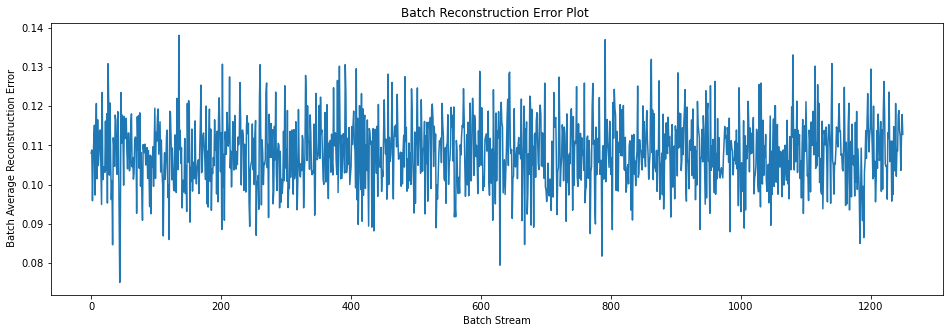

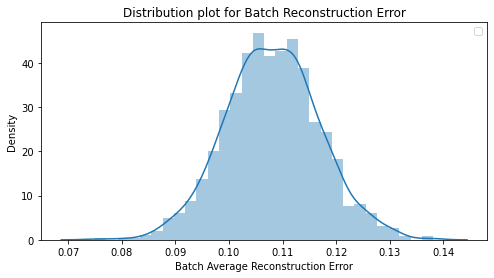

In [381]:
plot_batch_mse(batch_avg_mse)

In [273]:
Anderson_Darling(batch_avg_mse)

Statistic: 0.254
15.000: 0.574, data looks normal (fail to reject H0)
10.000: 0.654, data looks normal (fail to reject H0)
5.000: 0.785, data looks normal (fail to reject H0)
2.500: 0.915, data looks normal (fail to reject H0)
1.000: 1.089, data looks normal (fail to reject H0)


In [274]:
## computes loss threshold uisng IQR as well as ZScore from first test batch 
def compute_batch_threshold_testdata(batch_avg_mse):
    Q1=np.quantile(batch_avg_mse,0.25)
    Q3=np.quantile(batch_avg_mse,0.75)
    IQR=Q3-Q1
    thres_iqr=(Q3 + 1.5*IQR).round(4)
    #Z_SCORE
    mean=np.mean(batch_avg_mse)
    sigma=np.std(batch_avg_mse)
    thres_zscore=(mean+3*sigma).round(4)
    thresh_max=np.round((np.max(batch_avg_mse)),3)
    return thres_iqr, thres_zscore ,thresh_max

In [275]:
thres_iqr, thres_zscore ,thresh_max=compute_batch_threshold_testdata(batch_avg_mse)

In [276]:
thres_iqr, thres_zscore ,thresh_max

(0.1311, 0.1343, 0.138)

##  Count Threshold Computation 

### Instance Loss Batch Loss

In [280]:
def compute_instance_threshold_firstN_batches(batch_mse_values,N):
    zscore_list=[]
    #value_list=[]
    for k in range(0,N):
        value_list=batch_mse_values[k]
         #Z_SCORE
        mean=np.mean(value_list)
        sigma=np.std(value_list)
        thres_zscore=(mean+3*sigma).round(4)
        zscore_list.append(thres_zscore)
        #print (value_list)
        #print(zscore_list)
    return (np.mean(zscore_list).round(4)) , zscore_list  

In [291]:
instance_thresh,zscore_list=compute_instance_threshold_firstN_batches(batch_mse_values,10)

In [290]:
instance_thresh

0.2345

In [283]:
zscore_list

[0.2399,
 0.2252,
 0.2176,
 0.2478,
 0.2421,
 0.2757,
 0.2121,
 0.2607,
 0.2916,
 0.2249]

In [292]:
def threshold_exceed_count(batch_mse_values, thr):
    exceed_count={}
    for key in batch_mse_values.keys():
        count=0
        list=batch_mse_values[key]
        for a in range(0,len(list)):
            if list[a]>thr:
                count+=1
        exceed_count[key]=count 
    values = exceed_count.values()
    total = sum(values)
    return exceed_count,total

In [438]:
# Counts the MSE values exceeding threshold in each batch 
exceed_count,total=threshold_exceed_count(batch_mse_values,instance_thresh)

In [439]:
total

471

In [440]:
exceed_count;

In [441]:
exceed_list=[]
for key in exceed_count.keys():
    exceed_list.append(exceed_count[key])

In [442]:
count_thresh=np.max(exceed_list)

In [443]:
count_thresh

3

In [444]:
len(exceed_list)

1250

## Drift Detection Algorithm ( Algorithm 7)

In [426]:
def detect_drift(batch_mse, Thresh):
    count=0 ## counts the number of consecutive batches exceding threshold
    w_count=0 # Count of elements in Window. Windows contains batch number where batch MSE exceeds
              #threshold 
    w_index_list=[] # Contains indices of batches where batch MSE esceeds threshold 
    for i in range(0,len(batch_mse)):
        if(batch_mse[i])>Thresh:
            if(len(w_index_list)==0 or (i-w_index_list[-1]==1)):
                # Check if w_index_list is empty or its last entry is the previous batch
                    w_index_list.append(i)# then append this batch to w_index_list
            count+=1
            #if (i!= w_index_list[-1]
            #print ("Batch %d MSE exceeds Threshold" %i)
            print(w_index_list)
            if (count>2):# if for more than 2 consecutive batches  batch MSE esceeds threshold , then 
                         # confirm drift
                drift_batch=i-2 # at the first batch i this window

                print( " Drift Confirmed at Batch No : % d" %drift_batch)
            if len(w_index_list)>=1:
                #w_level=i-len(w_index_list)
                print("Warning Level at Batch",i)
        
        if(batch_mse[i])<Thresh:
            count=0 # reset count 
            #if len(w_index_list)>=1:
               # w_level=i-len(w_index_list)
                #print("Warning Level at Batch",w_level)
            if len(w_index_list)<=3:
                w_index_list=[]
        

### Apply Drift Detection on Validation Set-II / Test Set

In [427]:
 detect_drift2(batch_avg_mse, thres_zscore)

[135]
Warning Level at Batch 135
[791]
Warning Level at Batch 791


### Data Stream with Sudden Drift 

In [302]:
stream_sd=Sd[400000:800000]

In [371]:
len(stream_sd)

400000

In [303]:
predictions_sd=mse_predictions(stream_sd,encoder)

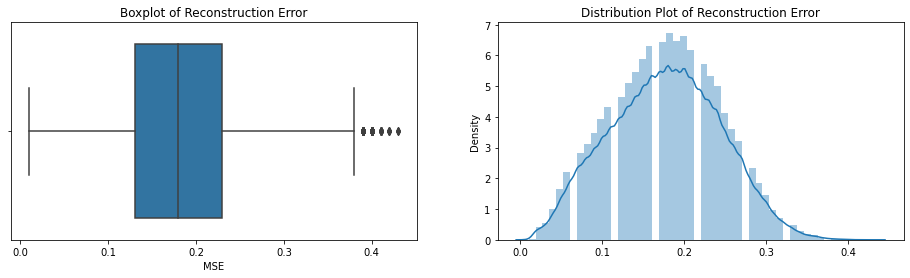

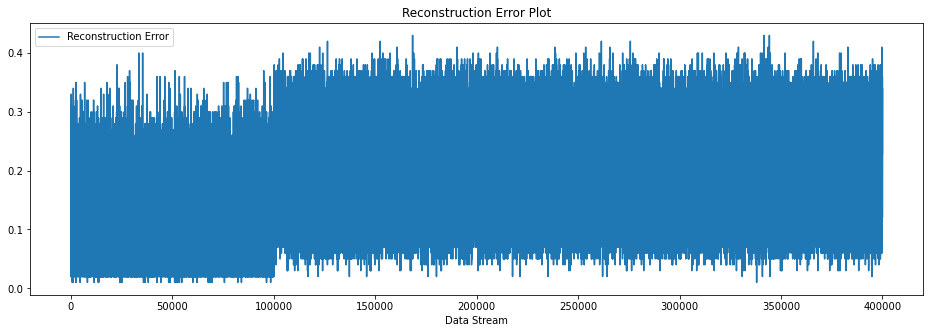

In [374]:
plot_results(predictions_sd)

## Make MSE Predictions in Batches and compute Batch MSE

In [305]:
# Here test  is a batch of size batch_size . This function computes average MSE for a batch passed 
def avg_mse_predictions(test, encoder,batch_size):
   
    test=np.array(test)
  
    mse_sum=0
    for i in range(0, test.shape[0]):
        ROW = np.array([test[i]])
        pred= encoder.predict(ROW) 
        mse = np.round(np.mean(np.power(test[i] - pred, 2)),5)
        mse_sum+=mse
        
    avg_mse=mse_sum/batch_size
    return avg_mse

In [306]:
## Computes batch MSE for all the batches in coming data stream data 
def compute_batch_mse(batches):
    batch_mse=[]
    for i in batches:
        avg_batch_mse=avg_mse_predictions(batches[i],encoder,32)
        batch_mse.append(avg_batch_mse)
    return batch_mse

In [307]:
batches_sd= make_batches(stream_sd,32)

In [308]:
batches_sd;

In [309]:
batch_avg_mse_sd,batch_mse_values_sd=check_all_batch_normality(batches_sd,encoder,32)

In [318]:
len(batch_avg_mse_sd)

12500

In [320]:
batch_avg_mse_sd;

In [322]:
batch_mse_values_sd;

In [454]:
exceed_count_sd,total_sd=threshold_exceed_count(batch_mse_values_sd,instance_thresh)

In [455]:
len(exceed_count_sd)

12500

In [456]:
exceed_count_sd;

In [459]:
exceed_list=[]
for key in exceed_count_sd.keys():
    exceed_list.append(exceed_count_sd[key])

In [460]:
len(exceed_list)

12500

## Plot BATCH MSE

No handles with labels found to put in legend.


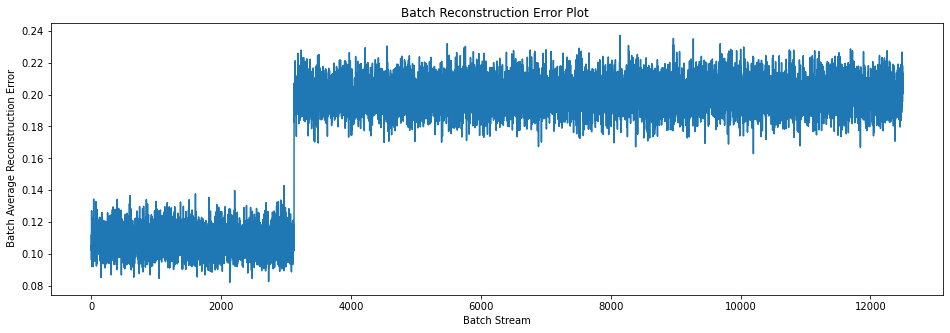

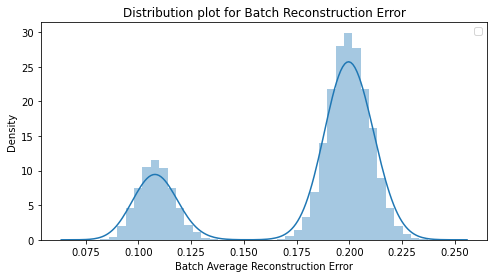

In [382]:
plot_batch_mse(batch_avg_mse_sd)

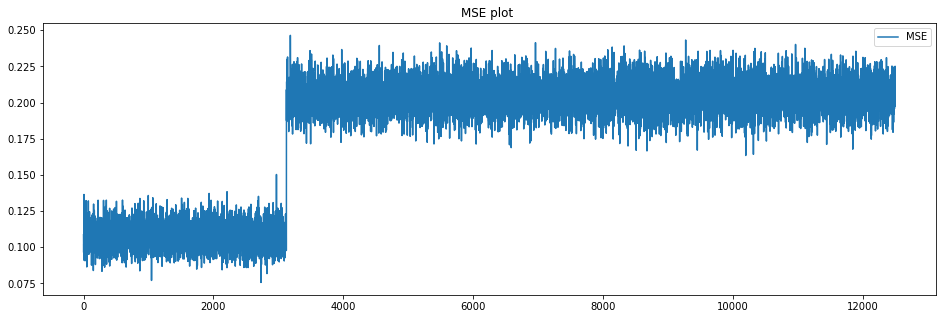

In [87]:
plot_batch_mse(batch_avg_mse_sd)

## Detect Sudden Drift 

In [187]:
thres_zscore

0.1348

In [472]:
a=batch_avg_mse_sd[0:3150]

In [473]:
# Drift Detection using Z-Score
# To limit the output , we are using first 3150 batches
detect_drift(a,thres_zscore)

[39]
Warning Level at Batch 39
[600]
Warning Level at Batch 600
[1606]
Warning Level at Batch 1606
[1813]
Warning Level at Batch 1813
[2210]
Warning Level at Batch 2210
[2971]
Warning Level at Batch 2971
[3125]
Warning Level at Batch 3125
[3125, 3126]
Warning Level at Batch 3126
[3125, 3126, 3127]
 Drift Confirmed at Batch No :  3125
Warning Level at Batch 3127
[3125, 3126, 3127, 3128]
 Drift Confirmed at Batch No :  3126
Warning Level at Batch 3128
[3125, 3126, 3127, 3128, 3129]
 Drift Confirmed at Batch No :  3127
Warning Level at Batch 3129
[3125, 3126, 3127, 3128, 3129, 3130]
 Drift Confirmed at Batch No :  3128
Warning Level at Batch 3130
[3125, 3126, 3127, 3128, 3129, 3130, 3131]
 Drift Confirmed at Batch No :  3129
Warning Level at Batch 3131
[3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132]
 Drift Confirmed at Batch No :  3130
Warning Level at Batch 3132
[3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133]
 Drift Confirmed at Batch No :  3131
Warning Level at Batch 3133
[3125,

# Working with Instance Threshold

In [162]:
def compute_batch_threshold_testdata2(batch_avg_mse):
    #val_loss=history['val_loss']
    ## Quartile Method 
    Q1=np.quantile(batch_avg_mse,0.25)
    Q3=np.quantile(batch_avg_mse,0.75)
    IQR=Q3-Q1
    thres_iqr=(Q3 + 1.5*IQR).round(4)
    #Z_SCORE
    mean=np.mean(batch_avg_mse)
    sigma=np.std(batch_avg_mse)
    thres_zscore=(mean+3*sigma).round(4)
    thresh_max=np.round((np.max(batch_avg_mse)),3)
    return thres_iqr, thres_zscore ,thresh_max

In [163]:
thres_iqr, thres_zscore ,thresh_max=compute_batch_threshold_testdata2(batch_avg_mse2)

In [164]:
len(exceed_count)

12500

In [327]:
Thresh=thres_zscore

### Algorithm 6

In [461]:
# This function takes two lists of Batch MSE and Exceed Counts along with Batch and Count Thresholds of Layer 2 AE
# If a bathc exceed both thresholds , warning is generated and for 3 consectutive batches drift is confirmed.
def detect_drift2(batch_mse,exceed_list, Thresh,count_thresh):
    n=0 # total number of batches where MSE exceeds threshold
    count=0 ## counts the number of consecutive batches exceding threshold
    w_count=0 # Count of elements in Window. Windows contains batch number where batch MSE exceeds
              #threshold 
    w_index_list=[] # Contains indices of batches where batch MSE esceeds threshold 
    for i in range(0,len(batch_mse)):
        #print (batch_mse)
        if((((batch_mse[i])>Thresh)) and (exceed_list[i]>count_thresh)):
            print(' Threshold exceeds at batch : {}'.format(i))
            n=n+1
            #print('Cumulative Batch Count Exceeding Threshold : {}'.format(n))
            if(len(w_index_list)==0 or (i-w_index_list[-1]==1)):
                # Check if w_index_list is empty or its last entry is the previous batch
                    w_index_list.append(i)# then append this batch to w_index_list
            count+=1
            #if (i!= w_index_list[-1]
            #print ("Batch %d MSE exceeds Threshold" %i)
            print(w_index_list)
            if (count>2):# if for more than nine consecutive batches , batch MSE esceeds threshold , then 
                         # confirm drift
                drift_batch=i-2 # at the first batch i this window

                print( " Drift Confirmed at Batch No : % d" %drift_batch)
            if (len(w_index_list)>=1 and len(w_index_list)<=2):
                w_level=i-len(w_index_list)
                print("Warning Level at Batch",i)
        
        if(batch_mse[i])<Thresh:
            count=0 # reset count 
            #if len(w_index_list)>=2:
               # w_level=i-len(w_index_list)
                #print("Warning Level at Batch",w_level)
            if len(w_index_list)<=3:
                w_index_list=[]
        
   

In [462]:
count_thresh

3

### Sudden Drift Detection uisng Algorithm 6

In [474]:
b=exceed_list[0:3150]

detect_drift2(batch_avg_mse_sd,exceed_list, Thresh,count_thresh)

In [475]:
# to limit the output , we have used  first 3150 batches only
detect_drift2(a,b, Thresh,count_thresh)

 Threshold exceeds at batch : 3125
[3125]
Warning Level at Batch 3125
 Threshold exceeds at batch : 3126
[3125, 3126]
Warning Level at Batch 3126
 Threshold exceeds at batch : 3127
[3125, 3126, 3127]
 Drift Confirmed at Batch No :  3125
 Threshold exceeds at batch : 3128
[3125, 3126, 3127, 3128]
 Drift Confirmed at Batch No :  3126
 Threshold exceeds at batch : 3129
[3125, 3126, 3127, 3128, 3129]
 Drift Confirmed at Batch No :  3127
 Threshold exceeds at batch : 3130
[3125, 3126, 3127, 3128, 3129, 3130]
 Drift Confirmed at Batch No :  3128
 Threshold exceeds at batch : 3131
[3125, 3126, 3127, 3128, 3129, 3130, 3131]
 Drift Confirmed at Batch No :  3129
 Threshold exceeds at batch : 3132
[3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132]
 Drift Confirmed at Batch No :  3130
 Threshold exceeds at batch : 3133
[3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133]
 Drift Confirmed at Batch No :  3131
 Threshold exceeds at batch : 3134
[3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3

## Part - B Working with Gradual Drift 

###  Gradual Drift Dataset : First 500000 records taken from S1 , [500000:600000] with a probability (600000-i)/100000 from S1 and with a probability (i-500000)/100000 from S2 , Rest taken from S2

In [477]:
Gd=pd.read_csv("gradualdrift_energy.txt",header=None , delimiter=' ')

In [478]:
Gd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1
1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1
2,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1
3,1,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,0


In [479]:
Gd.shape


(800000, 20)

No Trainng in required Here. We will use the same autoencoder as used in part -1 of this experiment

### Autoencoder is trained on first 400,000 records (10% of this data is used for validation)

In [480]:
Gd_train=Gd[0:400000]

In [481]:
train_gd,validation_set_gd,test_gd=encode_all(Gd_train)

In [482]:
train_gd.shape

(320000, 20)

In [483]:
test_gd.shape

(40000, 20)

In [484]:
validation_set_gd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
320000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
320001,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
320002,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
320003,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
320004,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
359996,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
359997,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
359998,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


#### Predictions on test Set

In [91]:
predictions_test_gd=mse_predictions(test_gd,encoder)

mean=0.097 ,max=0.353,min=0.016,variance=0.002


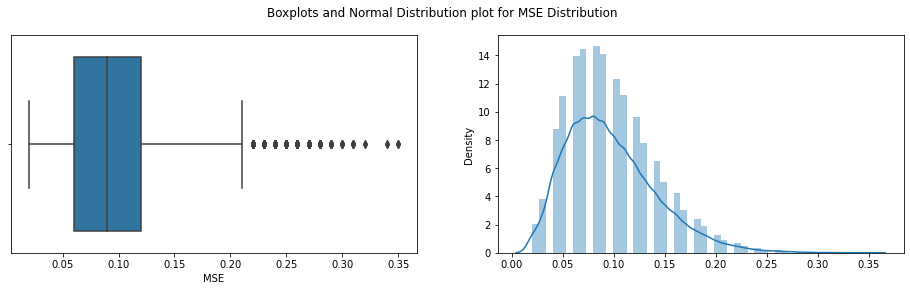

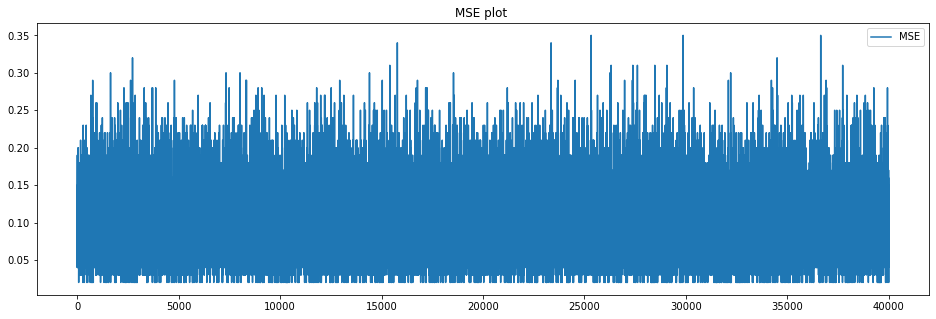

In [92]:
plot_results(predictions_test_gd)

## Monitoring the Data Stream for next 400,000 records

In [389]:
stream_gd=Gd[400000:800000]

In [464]:
# Getting MSE prediction on Test Data . We will use the same autoencoders trained in part -1 of this experiement as in both cases training data is same.
predictions_streams_gd=mse_predictions(stream_gd,encoder)

No handles with labels found to put in legend.


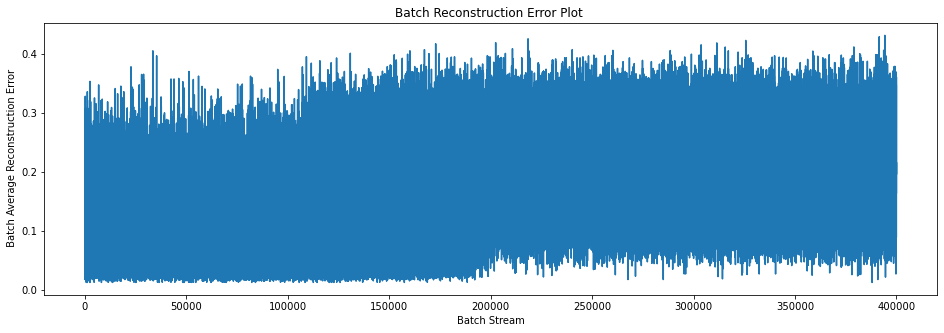

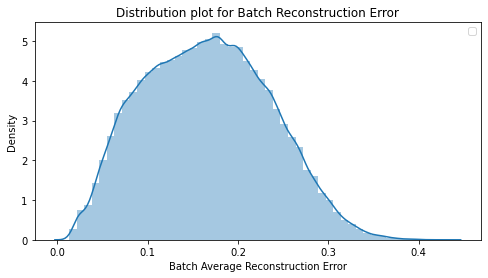

In [392]:
plot_batch_mse(predictions_streams_gd)

In [393]:
Anderson_Darling(predictions_streams_gd)

Statistic: 881.851
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


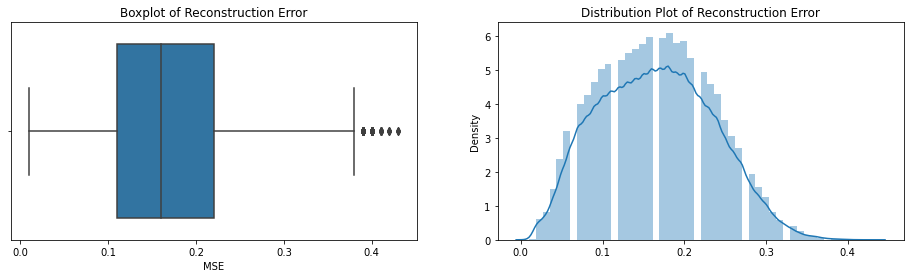

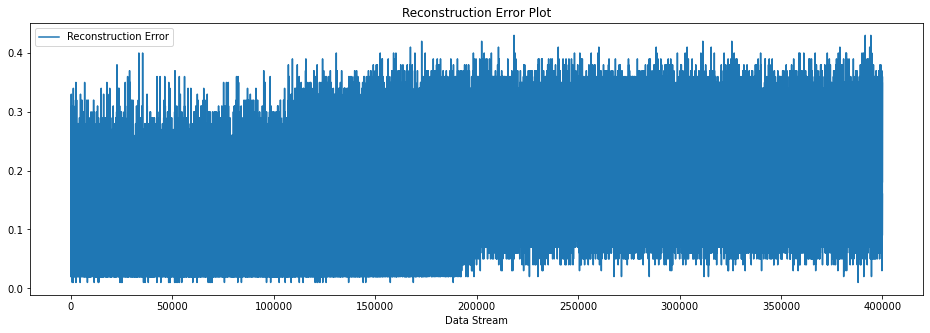

In [394]:
# Plotting the MSE
plot_results(predictions_streams_gd)

### Drift Detection : Woking in Batches

In [395]:
# Divide all the test data into batches of size=256
batches_gd=make_batches(stream_gd,32)

In [485]:
batches_gd;

In [397]:
batch_avg_mse_gd,batch_mse_values_gd=check_all_batch_normality(batches_gd,encoder,32)

No handles with labels found to put in legend.


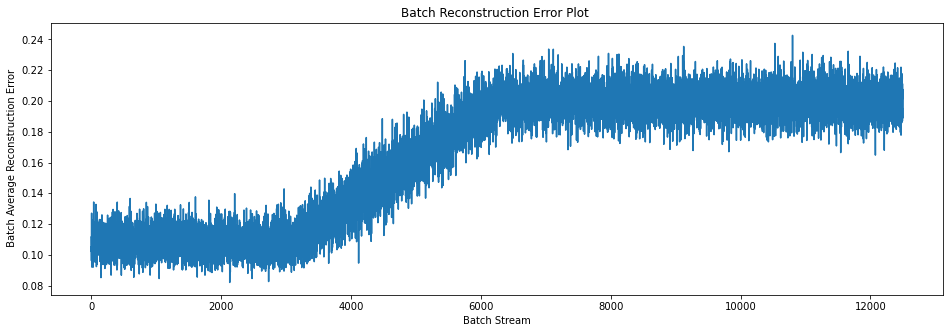

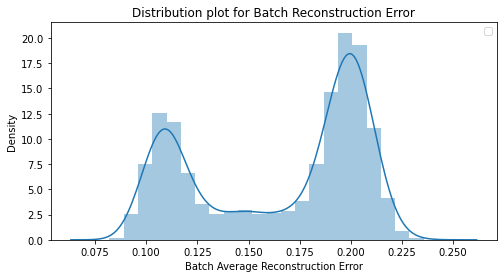

In [401]:
plot_batch_mse(batch_avg_mse_gd)

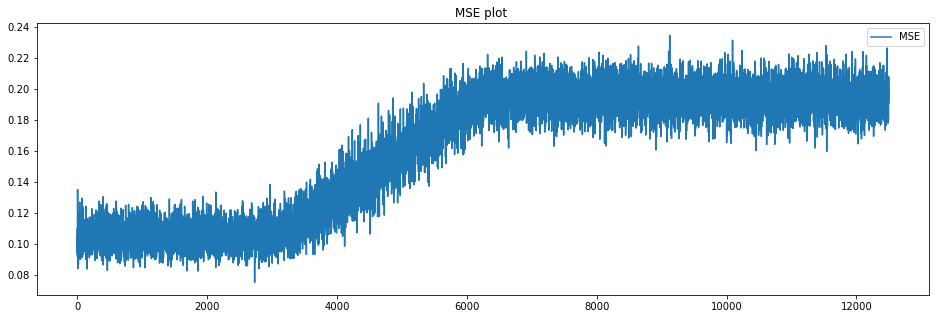

In [100]:
plot_batch_mse(batch_avg_mse_gd)

In [489]:
c=batch_avg_mse_gd[0:4000]

detect_drift(batch_avg_mse_gd,thres_zscore)

In [490]:
# Limiting Drift Detection to first 4000 batches
detect_drift(c,thres_zscore)

[39]
Warning Level at Batch 39
[600]
Warning Level at Batch 600
[1606]
Warning Level at Batch 1606
[1813]
Warning Level at Batch 1813
[2210]
Warning Level at Batch 2210
[2971]
Warning Level at Batch 2971
[3296]
Warning Level at Batch 3296
[3358]
Warning Level at Batch 3358
[3365]
Warning Level at Batch 3365
[3384]
Warning Level at Batch 3384
[3397]
Warning Level at Batch 3397
[3413]
Warning Level at Batch 3413
[3416]
Warning Level at Batch 3416
[3449]
Warning Level at Batch 3449
[3451]
Warning Level at Batch 3451
[3458]
Warning Level at Batch 3458
[3477]
Warning Level at Batch 3477
[3482]
Warning Level at Batch 3482
[3482, 3483]
Warning Level at Batch 3483
[3517]
Warning Level at Batch 3517
[3524]
Warning Level at Batch 3524
[3541]
Warning Level at Batch 3541
[3570]
Warning Level at Batch 3570
[3581]
Warning Level at Batch 3581
[3591]
Warning Level at Batch 3591
[3596]
Warning Level at Batch 3596
[3612]
Warning Level at Batch 3612
[3619]
Warning Level at Batch 3619
[3619, 3620]
Warning

### Incorporating Count Threshold 

In [409]:
exceed_count_gd,total_gd=threshold_exceed_count(batch_mse_values_gd,instance_thresh)

In [410]:
len(exceed_count_gd)

12500

In [344]:
exceed_count_gd;

In [411]:
exceed_list_gd=[]
for key in exceed_count_gd.keys():
    exceed_list_gd.append(exceed_count_gd[key])

In [413]:
len(exceed_list_gd)

12500

In [414]:
Thresh

0.1343

In [415]:
count_thresh

3

In [424]:
# This function takes two lists of Batch MSE and Exceed Counts along with Batch and Count Thresholds of Layer 2 AE
# If a bathc exceeds booth thresholds , warning is generated and for 3 consectutive batches drift is confirmed.
def detect_drift2(batch_mse,exceed_list, Thresh,count_thresh):
    n=0 # total number of batches where MSE exceeds threshold
    count=0 ## counts the number of consecutive batches exceding threshold
    w_count=0 # Count of elements in Window. Windows contains batch number where batch MSE exceeds
              #threshold 
    w_index_list=[] # Contains indices of batches where batch MSE esceeds threshold 
    for i in range(0,len(batch_mse)):
        #print (batch_mse)
        if((((batch_mse[i])>Thresh)) and (exceed_list[i]>count_thresh)):
            print(' Threshold exceeds at batch : {}'.format(i))
            n=n+1
            #print('Cumulative Batch Count Exceeding Threshold : {}'.format(n))
            if(len(w_index_list)==0 or (i-w_index_list[-1]==1)):
                # Check if w_index_list is empty or its last entry is the previous batch
                    w_index_list.append(i)# then append this batch to w_index_list
            count+=1
            #if (i!= w_index_list[-1]
            #print ("Batch %d MSE exceeds Threshold" %i)
            print(w_index_list)
            if (count>2):# if for more than 3 consecutive batches , batch MSE esceeds threshold , then 
                         # confirm drift
                drift_batch=i-2 # at the first batch i this window

                print( " Drift Confirmed at Batch No : % d" %drift_batch)
            if (len(w_index_list)>=1 and len(w_index_list)<=2):
                w_level=i-len(w_index_list)
                print("Warning Level at Batch",i)
        
        if(batch_mse[i])<Thresh:
            count=0 # reset count 
            #if len(w_index_list)>=2:
               # w_level=i-len(w_index_list)
                #print("Warning Level at Batch",w_level)
            if len(w_index_list)<=3:
                w_index_list=[]
        
   

In [417]:
batch_mse=batch_avg_mse_gd.copy()

In [418]:
exceed_list=exceed_list_gd.copy()

In [494]:
d=batch_mse[0:4000]
e=exceed_list[0:4000]

detect_drift4(batch_mse,exceed_list, Thresh,count_thresh)

In [492]:
# Limiting the output to first 4100 batches

In [495]:
detect_drift4(d,e, Thresh,count_thresh)

 Threshold exceeds at batch : 3296
[3296]
Warning Level at Batch 3296
 Threshold exceeds at batch : 3358
[3358]
Warning Level at Batch 3358
 Threshold exceeds at batch : 3365
[3365]
Warning Level at Batch 3365
 Threshold exceeds at batch : 3384
[3384]
Warning Level at Batch 3384
 Threshold exceeds at batch : 3397
[3397]
Warning Level at Batch 3397
 Threshold exceeds at batch : 3413
[3413]
Warning Level at Batch 3413
 Threshold exceeds at batch : 3416
[3416]
Warning Level at Batch 3416
 Threshold exceeds at batch : 3449
[3449]
Warning Level at Batch 3449
 Threshold exceeds at batch : 3451
[3451]
Warning Level at Batch 3451
 Threshold exceeds at batch : 3458
[3458]
Warning Level at Batch 3458
 Threshold exceeds at batch : 3477
[3477]
Warning Level at Batch 3477
 Threshold exceeds at batch : 3482
[3482]
Warning Level at Batch 3482
 Threshold exceeds at batch : 3483
[3482, 3483]
Warning Level at Batch 3483
 Threshold exceeds at batch : 3517
[3517]
Warning Level at Batch 3517
 Threshold exc